In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# DEFINISI GLOBALNE KONSTANTE

INPUT_FILE = '../data/narodne_pesme.txt'



In [ ]:
# FORMATIRAJ PODATKE

# Otvori pesme
with open(INPUT_FILE, 'r', encoding='utf-8') as file:
    pesme = file.read()
# Formatiraj podatke
slova = sorted(list(set(pesme)))

# Statistika
print(f"Првих 100 слова: {pesme[:100]}\n")
print(f"Дужина целог текста: {len(pesme)}\n")
print(f"Број слова: {len(slova)}\n")
print(f"Вокабулар: {''.join(slova)}\n")


Првих 100 слова: 


Кад се жени српски цар Стјепане,
надалеко запроси ђевојку,
у Леђану, граду латинскоме,
у латинско

Дужина целог текста: 475110

Број слова: 83

Вокабулар: 
 !'(),-.3:;?âêô̓ЂЈЉЊЋЏАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШабвгдежзиклмнопрстуфхцчшђјљњћџ–—’“”„



In [26]:
# TOkenizacija

stoi = {slovo: i for i, slovo in enumerate(slova)}
itos = {i: slovo for i, slovo in enumerate(slova)}
vocabulary_size = len(stoi.keys())

# Encoding / Decoding

encode = lambda s: [stoi[slovo] for slovo in s]
decode = lambda e: ''.join([itos[i] for i in e])

# Testiranje
test_string = "Пола пије, пола Шарцу даје"
encoded = encode(test_string)
decoded = decode(encoded)
print(f"Testni string: {test_string}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")


Testni string: Пола пије, пола Шарцу даје
Encoded: [37, 60, 57, 47, 1, 61, 55, 72, 52, 6, 1, 61, 60, 57, 47, 1, 46, 47, 62, 68, 65, 1, 51, 47, 72, 52]
Decoded: Пола пије, пола Шарцу даје


In [27]:
data = torch.tensor(encode(pesme), dtype=torch.long)
print(data.shape)


torch.Size([475110])


In [28]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print(xb.shape)
print(yb.shape)



torch.Size([4, 8])
torch.Size([4, 8])


In [34]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)

        if targets is None:
            loss = None
        else:
            logits = logits.view(-1, logits.shape[-1])
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context 
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            # logits is (B, T, vocab_size)
            logits = logits[:, -1, :] # note: using list [-1] to preserve the time dim
            # logits is (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            # probs is (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1)
            # idx_next is (B, 1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx

m = BigramLanguageModel(vocabulary_size)
out, loss = m(xb, yb)
print(out.shape, loss.item())

idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


torch.Size([32, 83]) 4.765726089477539

)Ажгњ–м.!џецљупјзТШнктжо’пљтê3Хочдсњ)“х3јцх:бЧ?Е–пг)—(јђЊКФЛЏЋЛЧ:ЉБЗЉгрЕитђнЦ.Х.дш̓'-„МзвЕпђБђиИеаГМ


In [35]:
optimizer = optim.AdamW(m.parameters(), lr=1e-3)


In [36]:
batch_size = 32

for steps in range(10000):
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.4820172786712646


In [37]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


Ниј,ију:
пра де са оно ћетаре,
ше г’Џџи два,
ГЉчесогије:
,
по тпрт ка!
„Утад вела,
Коседатану;
такња


### SELF ATTENTION BASICS


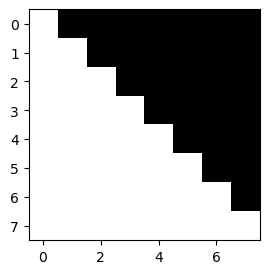

tensor([ 0.1808, -0.0700, -0.3596, -0.9152,  0.6258,  0.0255,  0.9545,  0.0643,
         0.3612,  1.1679, -1.3499, -0.5102,  0.2360, -0.2398, -0.9211,  1.5433,
         1.3488, -0.1396,  0.2858,  0.9651, -2.0371,  0.4931,  1.4870,  0.5910,
         0.1260, -1.5627, -1.1601, -0.3348,  0.4478, -0.8016,  1.5236,  2.5086],
       grad_fn=<SelectBackward0>)

In [54]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch size, sequence length, embedding dimensionality
x = torch.randn(B, T, C)
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B, T, head_size)
q = query(x) # (B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, T)



tril = torch.tril(torch.ones(T, T))
plt.figure(figsize=(3, 3))
plt.imshow(tril, cmap='gray')
plt.show()

wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
out[0, 0]










In [1]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]